# Prévision de l'évolution des taux d'inscription

✅ Connexion réussie à PostgreSQL !
📦 Version PostgreSQL : PostgreSQL 15.10, compiled by Visual C++ build 1942, 64-bit


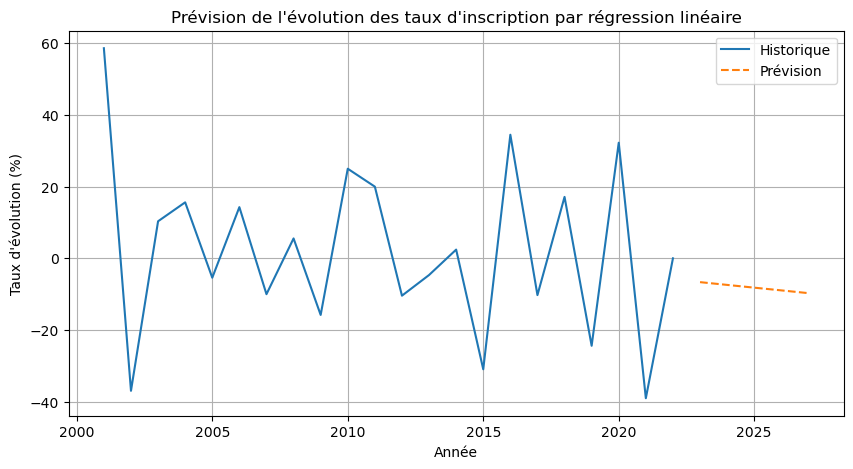

📈 Prévisions des taux d'évolution pour les années suivantes :
Année 2023: -6.64%
Année 2024: -7.41%
Année 2025: -8.18%
Année 2026: -8.94%
Année 2027: -9.71%

🔍 Métriques du modèle :
📉 Mean Squared Error (MSE): 545.782174277597
📊 R² (Coefficient de détermination): 0.04157756434906257


In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# === Paramètres de connexion ===
host = os.getenv("DB1_HOST")
port = os.getenv("DB1_PORT")
database = os.getenv("DB1_NAME")
username = os.getenv("DB1_USER")
password = os.getenv("DB1_PASSWORD")

# === Connexion à PostgreSQL ===
db_url = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

try:
    engine = create_engine(db_url)

    # Test de connexion
    with engine.connect() as connection:
        result = connection.execute(text("SELECT version();"))
        version = result.fetchone()
        print("✅ Connexion réussie à PostgreSQL !")
        print("📦 Version PostgreSQL :", version[0])

    # === Import des tables nécessaires pour l’objectif ML ===
    df_admission = pd.read_sql('SELECT * FROM "fact_Admission";', engine)
    df_dates = pd.read_sql("SELECT * FROM dimdates;", engine)

    # Extraire l'année de DateEnregistrement
    df_admission["AnneeEnregis"] = pd.to_datetime(df_admission["date_enregistrement"]).dt.year

    # === Calcul du taux d'évolution des inscriptions ===
    df_admission_grouped = df_admission.groupby("AnneeEnregis").agg(
        Nombre_Candidats_annee=pd.NamedAgg(column="fk_candidat", aggfunc="count"),
    ).reset_index()

    # Créer la colonne Inscriptions_Precedentes en décalant les années
    df_admission_grouped["Inscriptions_Precedentes"] = df_admission_grouped["Nombre_Candidats_annee"].shift(1)

    # Calcul du taux d'évolution des inscriptions
    df_admission_grouped["Taux_Evolution_Inscriptions"] = (
        (df_admission_grouped["Nombre_Candidats_annee"] - df_admission_grouped["Inscriptions_Precedentes"]) /
        df_admission_grouped["Inscriptions_Precedentes"] * 100
    )

    # Nettoyer les NaN pour l'année de base
    df_admission_grouped = df_admission_grouped.dropna(subset=["Taux_Evolution_Inscriptions"])

    # Vérifier si les données sont suffisantes pour modéliser
    if len(df_admission_grouped) > 1:
        # Appliquer une régression linéaire sur les années
        X = df_admission_grouped["AnneeEnregis"].values.reshape(-1, 1)  # Année
        y = df_admission_grouped["Taux_Evolution_Inscriptions"].values  # Taux d'évolution des inscriptions

        model = LinearRegression()
        model.fit(X, y)

        # Prédire pour les années suivantes (ex: 5 années supplémentaires)
        future_years = np.array(range(df_admission_grouped["AnneeEnregis"].max() + 1, df_admission_grouped["AnneeEnregis"].max() + 6)).reshape(-1, 1)
        future_predictions = model.predict(future_years)

        # Arrondir les années et les prédictions à des entiers
        future_years = future_years.astype(int)
        future_predictions = np.round(future_predictions, 2)

        # Tracer la courbe de la régression
        plt.figure(figsize=(10, 5))
        plt.plot(df_admission_grouped["AnneeEnregis"], df_admission_grouped["Taux_Evolution_Inscriptions"], label="Historique")
        plt.plot(future_years, future_predictions, label="Prévision", linestyle="--")
        plt.title("Prévision de l'évolution des taux d'inscription par régression linéaire")
        plt.xlabel("Année")
        plt.ylabel("Taux d'évolution (%)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Afficher les prévisions
        print("📈 Prévisions des taux d'évolution pour les années suivantes :")
        for i, pred in zip(future_years.flatten(), future_predictions):
            print(f"Année {i}: {pred}%")

        # Calcul des métriques du modèle
        y_pred_train = model.predict(X)
        mse = mean_squared_error(y, y_pred_train)
        r2 = r2_score(y, y_pred_train)

        # Affichage des métriques
        print(f"\n🔍 Métriques du modèle :")
        print(f"📉 Mean Squared Error (MSE): {mse}")
        print(f"📊 R² (Coefficient de détermination): {r2}")
    else:
        print("❌ Pas assez de données pour effectuer la prévision.")
except OperationalError as e:
    print("❌ Erreur de connexion à la base de données :")
    print(e)


### sauvgarder dans un table 

In [2]:
# Après les prédictions
# Créer un DataFrame pour les données historiques
df_historique = df_admission_grouped[["AnneeEnregis", "Taux_Evolution_Inscriptions"]].copy()
df_historique["Type"] = "Historique"

# Créer un DataFrame pour les prédictions
df_predictions = pd.DataFrame({
    "AnneeEnregis": future_years.flatten(),
    "Taux_Evolution_Inscriptions": future_predictions,
    "Type": "Prévision"
})

# Concaténer les deux
df_resultats = pd.concat([df_historique, df_predictions], ignore_index=True)

# Sauvegarder dans PostgreSQL
df_resultats.to_sql("Resultats_Modele1", engine, if_exists="replace", index=False)
print("✅ Résultats du Modèle 1 sauvegardés dans la table 'Resultats_Modele1'")

# Optionnel : Sauvegarder en CSV
df_resultats.to_csv("resultats_modele1.csv", index=False)
print("✅ Résultats du Modèle 1 sauvegardés dans 'resultats_modele1.csv'")

✅ Résultats du Modèle 1 sauvegardés dans la table 'Resultats_Modele1'
✅ Résultats du Modèle 1 sauvegardés dans 'resultats_modele1.csv'


# Prédire l'évolution des taux d'inscription en fonction des tendances du marché de l'emploi

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


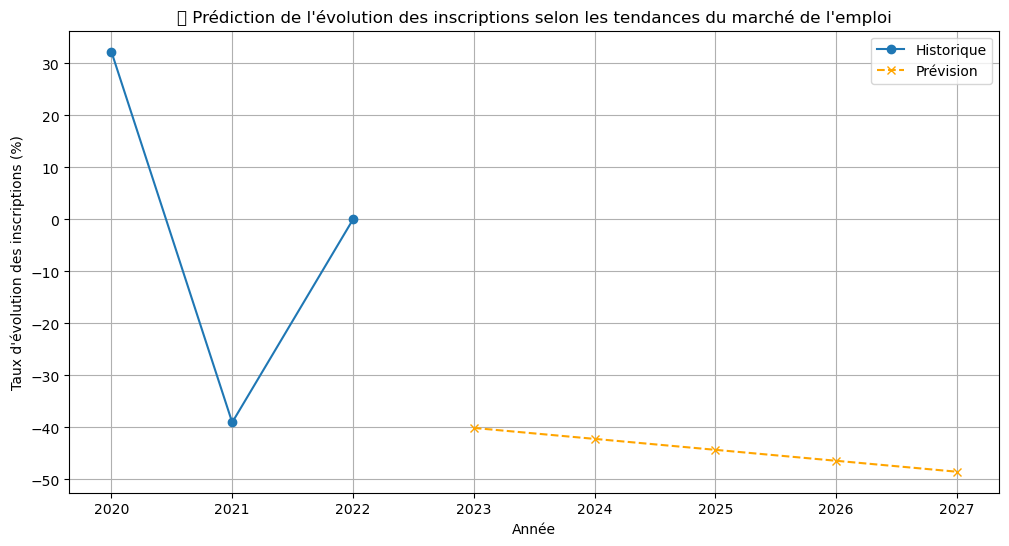

📈 MSE (Mean Squared Error): 209.5992265879746
📊 R² (Coefficient de détermination): 0.7532408824159531


In [5]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Connexion PostgreSQL
# === Paramètres de connexion ===
host = "localhost"
port = "5432"
database = "newdwadmission"
username = "postgres"
password = "azerty"
db_url = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"
engine = create_engine(db_url)

# === Import des données ===
df_admission = pd.read_sql('SELECT * FROM "fact_Admission";', engine)
df_employabilite = pd.read_sql('SELECT * FROM "fact_employabilite";', engine)

# === Préparer les données d'admission ===
df_admission["AnneeEnregis"] = pd.to_datetime(df_admission["date_enregistrement"]).dt.year
admission_grouped = df_admission.groupby("AnneeEnregis").agg(
    Nombre_Candidats_annee=pd.NamedAgg(column="fk_candidat", aggfunc="count")
).reset_index()

# Calcul des inscriptions précédentes et du taux d'évolution
admission_grouped["Inscriptions_Precedentes"] = admission_grouped["Nombre_Candidats_annee"].shift(1)
admission_grouped["Taux_Evolution_Inscriptions"] = (
    (admission_grouped["Nombre_Candidats_annee"] - admission_grouped["Inscriptions_Precedentes"]) /
    admission_grouped["Inscriptions_Precedentes"]
) * 100

# === Préparer les données du marché de l'emploi ===
emplois_grouped = df_employabilite.groupby("date_offre").agg(
    Nombre_Offres_emploi=pd.NamedAgg(column="fk_offre", aggfunc="count")
).reset_index()
# Convertir les colonnes en int pour assurer la compatibilité lors du merge
admission_grouped["AnneeEnregis"] = admission_grouped["AnneeEnregis"].astype(int)
emplois_grouped["AnneeOffre"] = emplois_grouped["date_offre"].astype(int)

# === Fusionner les données par année ===
df_merged = pd.merge(admission_grouped, emplois_grouped, left_on="AnneeEnregis", right_on="AnneeOffre", how="inner")

# === Modélisation ===
X = df_merged[["Nombre_Offres_emploi"]]
y = df_merged["Taux_Evolution_Inscriptions"]

model = LinearRegression()
model.fit(X, y)

# === Prédiction pour les futures tendances emploi ===
future_offres = np.array(range(X["Nombre_Offres_emploi"].max() + 10, X["Nombre_Offres_emploi"].max() + 60, 10)).reshape(-1, 1)
future_predictions = model.predict(future_offres)

# === Calcul des métriques du modèle ===
y_pred_train = model.predict(X)
mse = mean_squared_error(y, y_pred_train)
r2 = r2_score(y, y_pred_train)

# === Affichage ===
plt.figure(figsize=(12, 6))
plt.plot(df_merged["AnneeEnregis"], df_merged["Taux_Evolution_Inscriptions"], marker='o', label="Historique")
plt.plot(range(df_merged["AnneeEnregis"].max() + 1, df_merged["AnneeEnregis"].max() + 1 + len(future_predictions)),
         future_predictions, marker='x', linestyle='--', color='orange', label="Prévision")
plt.title("📊 Prédiction de l'évolution des inscriptions selon les tendances du marché de l'emploi")
plt.xlabel("Année")
plt.ylabel("Taux d'évolution des inscriptions (%)")
plt.legend()
plt.grid(True)
plt.show()

# Afficher les métriques du modèle
print(f"📈 MSE (Mean Squared Error): {mse}")
print(f"📊 R² (Coefficient de détermination): {r2}")


In [6]:
# Après les prédictions pour le Modèle 2
# Créer un DataFrame pour les données historiques
df_historique_model2 = df_merged[["AnneeEnregis", "Taux_Evolution_Inscriptions"]].copy()
df_historique_model2["Type"] = "Historique"

# Créer un DataFrame pour les prédictions
df_predictions_model2 = pd.DataFrame({
    "AnneeEnregis": range(df_merged["AnneeEnregis"].max() + 1, df_merged["AnneeEnregis"].max() + 1 + len(future_predictions)),
    "Taux_Evolution_Inscriptions": future_predictions,
    "Type": "Prévision"
})

# Concaténer les deux
df_resultats_model2 = pd.concat([df_historique_model2, df_predictions_model2], ignore_index=True)

# Sauvegarder dans PostgreSQL
df_resultats_model2.to_sql("Resultats_Modele2", engine, if_exists="replace", index=False)
print("✅ Résultats du Modèle 2 sauvegardés dans la table 'Resultats_Modele2'")

# Optionnel : Sauvegarder en CSV
df_resultats_model2.to_csv("resultats_modele2.csv", index=False)
print("✅ Résultats du Modèle 2 sauvegardés dans 'resultats_modele2.csv'")

✅ Résultats du Modèle 2 sauvegardés dans la table 'Resultats_Modele2'
✅ Résultats du Modèle 2 sauvegardés dans 'resultats_modele2.csv'
